# Hasil Evaluasi Algoritma AHP dalam pemberian Rekomendasi Keterampilan pada Program Double Track

Berikut adalah perhitungan evaluasi (akurasi, ranking, selisih ranking) pada penggunaan AHP sebagai algoritma pemberian rekomendasi keterampilan. Data pengujian diperoleh dari database [Website Rekomendasi Double Track](https://dt-rekomendasi.vercel.app). Subjek dari pengujian ini adalah siswa kelas 11 peserta program Double Track dari SMA Dharma Wanita Surabaya.

## Persiapan
Tahap persiapan dengan menginstall library `pandas` untuk mengolah file `.csv`. Kemudian dilanjutkan dengan mengunduh 2 file `.csv` yang berisi data rekomendasi yang didapatkan siswa setelah mengisi kuesioner dan data kuesioner ekspektasi yang telah diisi siswa.

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget "https://gist.githubusercontent.com/albugowy15/fab4fd6031f26ed2e615507923ed2c42/raw/d03b910b4afe8f1de8255a1e6ba09fd848c3c405/data-ekspektasi-smadhani.csv"

--2024-05-19 18:18:57--  https://gist.githubusercontent.com/albugowy15/fab4fd6031f26ed2e615507923ed2c42/raw/d03b910b4afe8f1de8255a1e6ba09fd848c3c405/data-ekspektasi-smadhani.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27200 (27K) [text/plain]
Saving to: ‘data-ekspektasi-smadhani.csv’

data-ekspektasi-sma 100%[===================>]  26.56K  --.-KB/s    in 0s      

2024-05-19 18:18:57 (133 MB/s) - ‘data-ekspektasi-smadhani.csv’ saved [27200/27200]



In [ ]:
!wget "https://gist.githubusercontent.com/albugowy15/de030fdfd7bb479bd1beb70a7045c94b/raw/651b79c42ac0b74035c9089a6be42cf2c07f0b72/data-rekomendasi-ahp-smadhani.csv"

--2024-05-19 18:19:02--  https://gist.githubusercontent.com/albugowy15/de030fdfd7bb479bd1beb70a7045c94b/raw/651b79c42ac0b74035c9089a6be42cf2c07f0b72/data-rekomendasi-ahp-smadhani.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43404 (42K) [text/plain]
Saving to: ‘data-rekomendasi-ahp-smadhani.csv’

data-rekomendasi-ah 100%[===================>]  42.39K  --.-KB/s    in 0.002s  

2024-05-19 18:19:02 (24.6 MB/s) - ‘data-rekomendasi-ahp-smadhani.csv’ saved [43404/43404]



In [ ]:
ahp_df = pd.read_csv("data-rekomendasi-ahp-smadhani.csv")
expects_df = pd.read_csv("data-ekspektasi-smadhani.csv")

File `data-rekomendasi-ahp-smadhani.csv` memiliki kolom


| Nama        | Tipe Data | Keterangan                           |
|-------------|-----------|--------------------------------------|
| Fullname    | String    | Nama lengkap siswa                   |
| Username    | String    | Username siswa untuk keperluan login |
| Score       | Float     | Skor perhitungan AHP                 |
| Alternative | String    | Rekomendasi bidang keterampilan      |

Data telah diurutkan berdasarkan `Fullname` secara `asc`, kemudian diurutkan lagi berdasarkan `Score` secara `desc`. Semakin tinggi `score` dari suatu bidang keterampilan, maka semakin tinggi ranking yang dimiliki bidang keterampilan tersebut.

In [ ]:
ahp_df.head()

,fullname,username,score,alternative
0,ABI PUTRA WICAKSONO,Abipww,0.312,Teknik Kendararaan Ringan/Motor
1,ABI PUTRA WICAKSONO,Abipww,0.288,Tata Kecantikan
2,ABI PUTRA WICAKSONO,Abipww,0.280,Tata Boga
3,ABI PUTRA WICAKSONO,Abipww,0.232,Multimedia
4,ABI PUTRA WICAKSONO,Abipww,0.200,Teknik Elektro


In [ ]:
ahp_df.dtypes

fullname        object
username        object
score          float64
alternative     object
dtype: object

In [ ]:
ahp_df.shape

(651, 4)

File `data-ekspektasi-smadhani.csv` memiliki kolom


| Nama        | Tipe Data | Keterangan                           |
|-------------|-----------|--------------------------------------|
| Fullname    | String    | Nama lengkap siswa                   |
| Username    | String    | Username siswa untuk keperluan login |
| Rank       | Integer     | Ranking bidang keterampilan                 |
| Alternative | String    | Rekomendasi bidang keterampilan      |

Data telah diurutkan berdasarkan `Fullname` secara `asc`, kemudian diurutkan lagi berdasarkan `Ranking` secara `asc`.

In [ ]:
expects_df.head()

,fullname,username,rank,alternative
0,ABI PUTRA WICAKSONO,Abipww,1,Teknik Kendararaan Ringan/Motor
1,ABI PUTRA WICAKSONO,Abipww,2,Teknik Listrik
2,ABI PUTRA WICAKSONO,Abipww,3,Tata Boga
3,ABI PUTRA WICAKSONO,Abipww,4,Multimedia
4,ABI PUTRA WICAKSONO,Abipww,5,Teknik Elektro


In [ ]:
expects_df.dtypes

fullname       object
username       object
rank            int64
alternative    object
dtype: object

In [ ]:
expects_df.shape

(546, 4)

## Perhitungan Ranking
Berikut adalah kode untuk menentukan ranking bidang keterampilan berdasarkan score yang dihasilkan metode AHP. Perhitungan ranking di bawah memungkinkan lebih dari satu bidang keterampilan untuk menempati ranking yang sama. Sebagai contoh, multimedia dan teknik listrik memiliki score yang sama yaitu 0.2321. Maka kedua bidang keterampilan tersebut akan ditempatkan ke satu ranking yang sama.

In [ ]:
usernames = ahp_df["username"].unique().tolist()
print("total users:", len(usernames))

total users: 93


In [ ]:
def calculate_ranks(username, scores):
  curr_rank = 1
  curr_score = scores[0]
  rank = []
  for i, score in enumerate(scores):
    if score < curr_score:
      curr_rank +=1
      curr_score = score
    rank.append(curr_rank)
  return rank

In [ ]:
all_ranks = []

for username in usernames:
  user_data = ahp_df[ahp_df["username"] == username]
  rank = calculate_ranks(username, user_data['score'].tolist())
  all_ranks.append(rank)

ahp_df["ranking"] = list(chain.from_iterable(all_ranks))
ahp_df.head()

,fullname,username,score,alternative,ranking
0,ABI PUTRA WICAKSONO,Abipww,0.312,Teknik Kendararaan Ringan/Motor,1
1,ABI PUTRA WICAKSONO,Abipww,0.288,Tata Kecantikan,2
2,ABI PUTRA WICAKSONO,Abipww,0.280,Tata Boga,3
3,ABI PUTRA WICAKSONO,Abipww,0.232,Multimedia,4
4,ABI PUTRA WICAKSONO,Abipww,0.200,Teknik Elektro,5


## Evaluasi

Berikut kode untuk evaluasi kebenaran dari metode AHP. Setelah didapatkan ranking dari setiap bidang keterampilan, dilanjutkan dengan menghitung selisih ranking yang didapatkan dari AHP dengan ranking bidang keterampilan pada ekspektasi.

Selanjutnya dihitung akurasi dalam bentuk persentase untuk mengetahui seberapa tepat AHP dalam memprediksi ranking bidang keterampilan sesuai dengan ekspektasi siswa.

In [ ]:
rank_difs = []
accur_percentages = []
for index, row in ahp_df.iterrows():
  username = row["username"]
  alternative = row["alternative"]
  rank = int(row["ranking"])

  user_expects = expects_df[expects_df["username"] == username]
  expect_rank = user_expects[user_expects["alternative"] == alternative]


  if len(expect_rank["rank"]) == 0:
    rank_difs.append(None)
    accur_percentages.append(None)
  else :
    rank_diff = int(expect_rank["rank"].values[0]) - rank
    rank_difs.append(rank_diff)
    accur_percentage = (7 - abs(rank_diff))/7 * 100
    accur_percentages.append(accur_percentage)

ahp_df["rank_diff"] = rank_difs
ahp_df["accur_percentage"] = accur_percentages

In [ ]:
ahp_df = ahp_df.dropna()
ahp_df

,fullname,username,score,alternative,ranking,rank_diff,accur_percentage
0,ABI PUTRA WICAKSONO,Abipww,0.312000,Teknik Kendararaan Ringan/Motor,1,0.0,100.000000
1,ABI PUTRA WICAKSONO,Abipww,0.288000,Tata Kecantikan,2,4.0,42.857143
2,ABI PUTRA WICAKSONO,Abipww,0.280000,Tata Boga,3,0.0,100.000000
3,ABI PUTRA WICAKSONO,Abipww,0.232000,Multimedia,4,0.0,100.000000
4,ABI PUTRA WICAKSONO,Abipww,0.200000,Teknik Elektro,5,0.0,100.000000
...,...,...,...,...,...,...,...
639,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.231122,Tata Kecantikan,3,1.0,85.714286
640,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.231122,Teknik Kendararaan Ringan/Motor,3,4.0,42.857143
641,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.218612,Tata Busana,4,-1.0,85.714286
642,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.195935,Teknik Elektro,5,0.0,100.000000


In [ ]:
ahp_df.shape

(539, 7)

In [ ]:
usernames = ahp_df["username"].unique().tolist()
print("total users:", len(usernames))

total users: 77


Berikut perhitungan evaluasi P3, P5, dan P7
- P3 adalah rata-rata akurasi ranking bidang keterampilan AHP untuk urutan ranking 1 - 3
- P5 adalah rata-rata akurasi ranking bidang keterampilan AHP untuk urutan ranking 1 - 5
- P7 adalah rata-rata akurasi ranking bidang keterampilan AHP untuk urutan ranking 1 - 7

Pembagian segmen ini bertujuan untuk mengetahui seberapa baik AHP menghasilkan rekomendasi bidang keterampilan dengan ranking 3 teratas, 5 teratas, dan 7 teratas.


In [ ]:
p3_list = []
p5_list = []
p7_list = []

for username in usernames:
  user_ahp = ahp_df[ahp_df["username"] == username]
  acc = user_ahp["accur_percentage"]

  p3 = acc.head(3).mean()
  p3_list.extend([p3] * 7)

  p5 = acc.head(5).mean()
  p5_list.extend([p5] * 7)

  p7 = acc.mean()
  p7_list.extend([p7] * 7)

ahp_df["P3"] = p3_list
ahp_df["P5"] = p5_list
ahp_df["P7"] = p7_list

In [ ]:
ahp_df.head(14)

,fullname,username,score,alternative,ranking,rank_diff,accur_percentage,P3,P5,P7
0,ABI PUTRA WICAKSONO,Abipww,0.312000,Teknik Kendararaan Ringan/Motor,1,0.0,100.000000,80.952381,88.571429,79.591837
1,ABI PUTRA WICAKSONO,Abipww,0.288000,Tata Kecantikan,2,4.0,42.857143,80.952381,88.571429,79.591837
2,ABI PUTRA WICAKSONO,Abipww,0.280000,Tata Boga,3,0.0,100.000000,80.952381,88.571429,79.591837
3,ABI PUTRA WICAKSONO,Abipww,0.232000,Multimedia,4,0.0,100.000000,80.952381,88.571429,79.591837
4,ABI PUTRA WICAKSONO,Abipww,0.200000,Teknik Elektro,5,0.0,100.000000,80.952381,88.571429,79.591837
5,ABI PUTRA WICAKSONO,Abipww,0.176000,Tata Busana,6,1.0,85.714286,80.952381,88.571429,79.591837
6,ABI PUTRA WICAKSONO,Abipww,0.168000,Teknik Listrik,7,-5.0,28.571429,80.952381,88.571429,79.591837
7,ACHMAD SYAIFULLAH,Syaifullah,0.260350,Teknik Kendararaan Ringan/Motor,1,4.0,42.857143,52.380952,57.142857,63.265306
8,ACHMAD SYAIFULLAH,Syaifullah,0.249283,Tata Kecantikan,2,5.0,28.571429,52.380952,57.142857,63.265306
9,ACHMAD SYAIFULLAH,Syaifullah,0.239909,Tata Boga,3,-1.0,85.714286,52.380952,57.142857,63.265306


Kode berikut untuk menghitung rata-rata akurasi.

In [ ]:
## total avg acc
acc_avg = ahp_df["accur_percentage"].mean()
acc_avg

78.45216008481314

In [ ]:
p3 = ahp_df["P3"].unique()
p3_avg = p3.mean()
p3_min = p3.min()
p3_max = p3.max()
print("p3_avg:", p3_avg)
print("p3_min:", p3_min)
print("p3_max:", p3_max)

p3_avg: 71.72619047619048
p3_min: 42.857142857142854
p3_max: 100.0


In [ ]:
p5 = ahp_df["P5"].unique()
p5_avg = p5.mean()
p5_min = p5.min()
p5_max = p5.max()
print("p5_avg:", p5_avg)
print("p5_min:", p5_min)
print("p5_max:", p5_max)

p5_avg: 74.28571428571428
p5_min: 48.57142857142857
p5_max: 94.28571428571429


In [ ]:
p7 = ahp_df["P7"].unique()
p7_avg = p7.mean()
p7_min = p7.min()
p7_max = p7.max()
print("p7_avg:", p7_avg)
print("p7_min:", p7_min)
print("p7_max:", p7_max)

p7_avg: 74.75832438238453
p7_min: 51.0204081632653
p7_max: 91.83673469387756


In [ ]:
ahp_df.to_csv("evaluasi_ahp.csv")

In [ ]:
ahp_df

,fullname,username,score,alternative,ranking,rank_diff,accur_percentage,P3,P5,P7
0,ABI PUTRA WICAKSONO,Abipww,0.312000,Teknik Kendararaan Ringan/Motor,1,0.0,100.000000,80.952381,88.571429,79.591837
1,ABI PUTRA WICAKSONO,Abipww,0.288000,Tata Kecantikan,2,4.0,42.857143,80.952381,88.571429,79.591837
2,ABI PUTRA WICAKSONO,Abipww,0.280000,Tata Boga,3,0.0,100.000000,80.952381,88.571429,79.591837
3,ABI PUTRA WICAKSONO,Abipww,0.232000,Multimedia,4,0.0,100.000000,80.952381,88.571429,79.591837
4,ABI PUTRA WICAKSONO,Abipww,0.200000,Teknik Elektro,5,0.0,100.000000,80.952381,88.571429,79.591837
...,...,...,...,...,...,...,...,...,...,...
639,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.231122,Tata Kecantikan,3,1.0,85.714286,85.714286,77.142857,83.673469
640,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.231122,Teknik Kendararaan Ringan/Motor,3,4.0,42.857143,85.714286,77.142857,83.673469
641,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.218612,Tata Busana,4,-1.0,85.714286,85.714286,77.142857,83.673469
642,YUSRIL BINTANG TITIAN HATI,bintangyusril,0.195935,Teknik Elektro,5,0.0,100.000000,85.714286,77.142857,83.673469


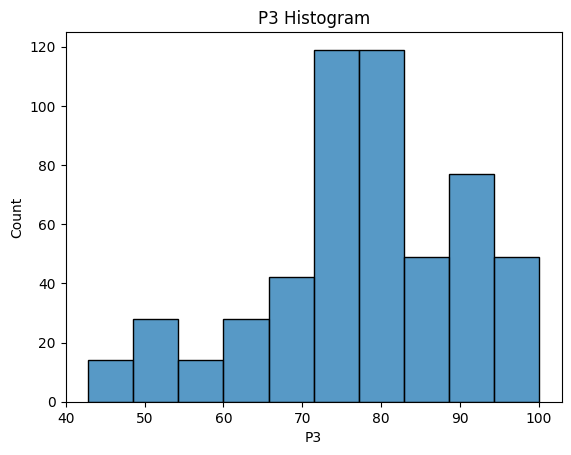

In [ ]:
sns.histplot(data=ahp_df["P3"],bins=10)
plt.title('P3 Histogram')
plt.show()

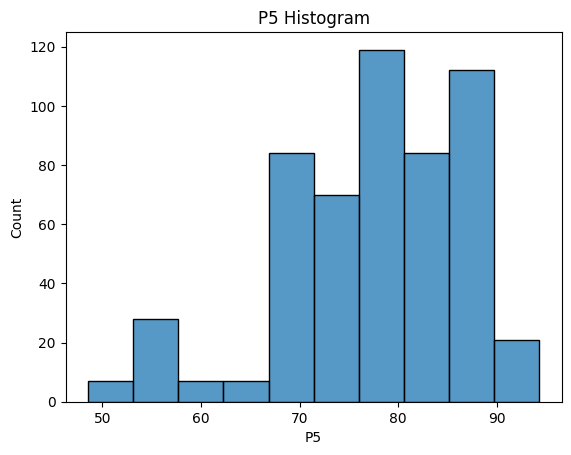

In [ ]:
sns.histplot(data=ahp_df["P5"],bins=10)
plt.title('P5 Histogram')
plt.show()

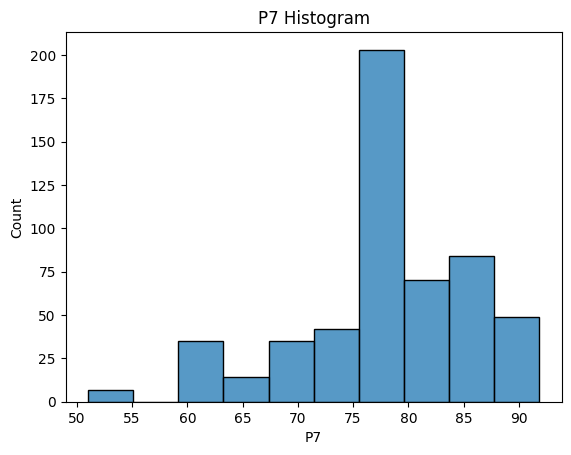

In [ ]:
sns.histplot(data=ahp_df["P7"],bins=10)
plt.title('P7 Histogram')
plt.show()